## Boundless DAS

In [ ]:
__author__ = "Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce one key result of [the Boundless DAS paper](https://arxiv.org/pdf/2305.08809). It uses the same pricing tag dataset as in the paper. Additionally, it focuses on finding alignment for the left boundary check only. 

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
import torch
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup,AutoTokenizer, AutoModelForCausalLM
from torch.nn import CrossEntropyLoss
from tutorial_price_tagging_utils import (
    factual_sampler,
    bound_alignment_sampler,
    lower_bound_alignment_example_sampler,
)

from pyvene import (
    IntervenableModel,
    BoundlessRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_llama, create_gpt2
from pyvene import set_seed, count_parameters

/home/grantsrb/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def create_model(model_name="meta-llama/Llama-2-7b-hf"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
       model_name, torch_dtype=torch.bfloat16, device_map="cuda")
    return None, tokenizer, model 

In [5]:
model_names = [ "llama", "llama", ]
models = []
tokenizers = []
for model_name in model_names:
    try:
        _, tokenizer, model = create_model(model_name=model_name)
    except: #TODO: make less hacky
        _, tokenizer, model = create_llama()
    
    model.to("cuda")  # single gpu
    model.eval()  # always no grad on the model
    models.append(model)
    tokenizers.append(tokenizer)

Loading checkpoint shards:   0%|          | 0/34 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


loaded model


Loading checkpoint shards:   0%|          | 0/34 [00:00<?, ?it/s]

loaded model


### Factual performance of instruct-tuned LLaMA-7B

In [6]:
dataloaders = []
for tokenizer in tokenizers:
    raw_prealign = factual_sampler(tokenizer, 5000, game="pricing_tag")
    prealign_dataset = Dataset.from_dict(
        {"input_ids": raw_prealign[0], "labels": raw_prealign[1]}
    )
    prealign_dataset.set_format("torch", columns=["input_ids", "labels"])
    prealign_dataloader = DataLoader(
        prealign_dataset,
        batch_size=8
    )
    dataloaders.append(prealign_dataloader)

In [46]:
hidden_states = { m: [] for m in models }
with torch.no_grad():
    for loop, (dloader,model) in enumerate(zip(dataloaders, models)):
        total_count = 0
        correct_count = 0
        for step, inputs in enumerate(tqdm(dloader)):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to(model.device)
    
            # aligning forward!
            outputs = model(
                input_ids=inputs["input_ids"],
                labels=inputs["labels"],
                output_hidden_states=True,
            )
            
            hidden_states[model].append(
                [h.cpu().data for h in outputs.hidden_states]
            )
    
            actual_test_labels = inputs["labels"][:, -1]
            pred_test_labels = torch.argmax(outputs.logits[:, -1], dim=-1)
    
            correct_labels = actual_test_labels == pred_test_labels
    
            total_count += len(correct_labels)
            correct_count += correct_labels.sum().tolist()
        current_acc = round(correct_count / total_count, 2)
        print("Model:", type(model))
        print(f"[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: {current_acc}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:50<00:00,  5.65it/s]


Model: <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>
[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: 0.92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:52<00:00,  5.55it/s]

Model: <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>
[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: 0.92


### Create training dataset for our trainable intervention (Boundless DAS)

In [47]:
print(len(hidden_states[model]))
print(len(hidden_states[model][0]))
print(len(hidden_states[model][0][0]))
print(len(hidden_states[model][0][0].shape))

625
33
8
3


In [52]:
hidden_states[models[0]][0][15][0]

tensor([[ 0.2773, -0.1621,  0.0400,  ...,  0.5742,  0.2852,  1.5156],
        [ 0.3223, -0.2520,  0.0427,  ..., -0.2139, -0.4453, -0.5703],
        [ 0.1211, -0.6523, -0.8945,  ..., -0.8672, -0.2432,  0.5469],
        ...,
        [-0.9219, -0.1094,  1.0625,  ...,  0.7266,  0.0488, -0.5703],
        [-0.5156, -0.3926,  0.3281,  ...,  0.2812, -0.4160, -1.0625],
        [-0.5820,  0.1895,  0.4727,  ...,  0.0781,  0.1650, -0.1367]],
       dtype=torch.bfloat16)

In [53]:
hidden_states[models[1]][0][15][0]

tensor([[ 0.2773, -0.1621,  0.0400,  ...,  0.5742,  0.2852,  1.5156],
        [ 0.3223, -0.2520,  0.0427,  ..., -0.2139, -0.4453, -0.5703],
        [ 0.1211, -0.6523, -0.8945,  ..., -0.8672, -0.2432,  0.5469],
        ...,
        [-0.9219, -0.1094,  1.0625,  ...,  0.7266,  0.0488, -0.5703],
        [-0.5156, -0.3926,  0.3281,  ...,  0.2812, -0.4160, -1.0625],
        [-0.5820,  0.1895,  0.4727,  ...,  0.0781,  0.1650, -0.1367]],
       dtype=torch.bfloat16)

In [55]:
import matplotlib.pyplot as plt
import numpy as np

In [56]:
def correlation_mtx(matrix):
    matrix = matrix.float()
    # Step 1: Center the matrix (subtract the mean of each column)
    mean = matrix.mean(dim=0, keepdim=True)  # Mean for each column
    centered_matrix = matrix - mean
    # Step 2: Compute covariance matrix
    cov_matrix = centered_matrix.T @ centered_matrix / (matrix.size(0) - 1)  # Unbiased covariance
    # Step 3: Normalize by the standard deviations
    std_dev = torch.sqrt(torch.diag(cov_matrix))
    correlation_matrix = cov_matrix / (std_dev[:, None] * std_dev[None, :])  # Outer product of std_dev for normalization
    # Print the resulting correlation matrix
    return correlation_matrix

In [57]:
token_idx = -1
cor_mtxs = {m: [] for m in models}
for model in models:
    for layer in tqdm(range(len(hidden_states[model][0]))):
        h = torch.cat([
            hs[layer][:,token_idx] for hs in hidden_states[model]
        ], dim=0)
        cor = correlation_mtx(h.T)
        #z = (h - h.mean(1)[:,None])/h.std(1)[:,None]
        #cor = torch.matmul(z, z.T)/(h.shape[-1]-1) # (N,N)
        cor_mtxs[model].append( cor )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:05<00:00,  6.49it/s]


In [58]:
hidden_states[models[0]][0][15][0]

tensor([[ 0.2773, -0.1621,  0.0400,  ...,  0.5742,  0.2852,  1.5156],
        [ 0.3223, -0.2520,  0.0427,  ..., -0.2139, -0.4453, -0.5703],
        [ 0.1211, -0.6523, -0.8945,  ..., -0.8672, -0.2432,  0.5469],
        ...,
        [-0.9219, -0.1094,  1.0625,  ...,  0.7266,  0.0488, -0.5703],
        [-0.5156, -0.3926,  0.3281,  ...,  0.2812, -0.4160, -1.0625],
        [-0.5820,  0.1895,  0.4727,  ...,  0.0781,  0.1650, -0.1367]],
       dtype=torch.bfloat16)

In [59]:
hidden_states[models[1]][0][15][0]

tensor([[ 0.2773, -0.1621,  0.0400,  ...,  0.5742,  0.2852,  1.5156],
        [ 0.3223, -0.2520,  0.0427,  ..., -0.2139, -0.4453, -0.5703],
        [ 0.1211, -0.6523, -0.8945,  ..., -0.8672, -0.2432,  0.5469],
        ...,
        [-0.9219, -0.1094,  1.0625,  ...,  0.7266,  0.0488, -0.5703],
        [-0.5156, -0.3926,  0.3281,  ...,  0.2812, -0.4160, -1.0625],
        [-0.5820,  0.1895,  0.4727,  ...,  0.0781,  0.1650, -0.1367]],
       dtype=torch.bfloat16)

Min: tensor(0.9205)
Max: tensor(1.0000)


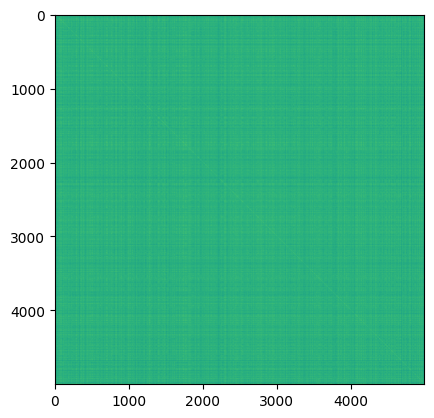

In [60]:
layer = -1
print("Min:", torch.min(cor_mtxs[model][layer]))
print("Max:", torch.max(cor_mtxs[model][layer]))
plt.imshow(cor_mtxs[model][layer].float().numpy())
plt.show()

In [61]:
sims.shape

torch.Size([33, 33])

In [62]:
l2

32

In [68]:
for l1 in range(layer_sizes[0]):
    assert torch.all(cor_mtxs[models[0]][l1]==cor_mtxs[models[1]][l1])

In [69]:
layer_sizes = [len(cor_mtxs[m]) for m in models]
sims = torch.zeros(layer_sizes)
for l1 in tqdm(range(layer_sizes[0])):
    c1 = cor_mtxs[models[0]][l1].reshape(-1)
    c1 = (c1-c1.mean())/c1.std()
    for l2 in range(layer_sizes[1]):
        c2 = cor_mtxs[models[1]][l2].reshape(-1)
        c2 = (c2-c2.mean())/c2.std()
        sims[l1,l2] = ( c1*c2 ).mean()

        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [01:03<00:00,  1.92s/it]


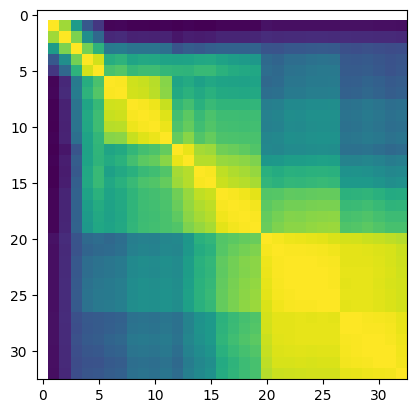

In [70]:
plt.imshow(sims.numpy())

In [6]:
set_seed(42)

###################
# data loaders
###################
raw_data = bound_alignment_sampler(
    tokenizer, 10000, [lower_bound_alignment_example_sampler]
)

raw_train = (
    raw_data[0][:8000],
    raw_data[1][:8000],
    raw_data[2][:8000],
    raw_data[3][:8000],
)
raw_eval = (
    raw_data[0][8000:9000],
    raw_data[1][8000:9000],
    raw_data[2][8000:9000],
    raw_data[3][8000:9000],
)
raw_test = (
    raw_data[0][9000:],
    raw_data[1][9000:],
    raw_data[2][9000:],
    raw_data[3][9000:],
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],  # we will not use this field
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0],
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],  # we will not use this field
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=16,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0],
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],  # we will not use this field
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
)

### Boundless DAS on Position-aligned Tokens

In [7]:
def simple_boundless_das_position_config(model_type, intervention_type, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                intervention_type,  # intervention type
            ),
        ],
        intervention_types=BoundlessRotatedSpaceIntervention,
    )
    return config


config = simple_boundless_das_position_config(
    type(llama), "block_output", 15
)
intervenable = IntervenableModel(config, llama)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()

In [8]:
t_total = int(len(train_dataloader) * 3)
warm_up_steps = 0.1 * t_total
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    optimizer_params += [{"params": v[0].intervention_boundaries, "lr": 1e-2}]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps, num_training_steps=t_total
)


# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = actual_test_labels == pred_test_labels
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}


epochs = 3
gradient_accumulation_steps = 4
total_step = 0
target_total_step = len(train_dataloader) * epochs
temperature_start = 50.0
temperature_end = 0.1
temperature_schedule = (
    torch.linspace(temperature_start, temperature_end, target_total_step)
    .to(torch.bfloat16)
    .to("cuda")
)
intervenable.set_temperature(temperature_schedule[total_step])


def calculate_loss(logits, labels):
    shift_logits = logits[..., :, :].contiguous()
    shift_labels = labels[..., :].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, intervenable.model_config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)

    for k, v in intervenable.interventions.items():
        boundary_loss = 1.0 * v[0].intervention_boundaries.sum()
    loss += boundary_loss

    return loss

In [9]:
intervenable.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(intervenable.model))
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, desc=f"Epoch: {epoch}", position=0, leave=True
    )
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [inputs["labels"]]
        )

        # loss and backprop
        loss = calculate_loss(counterfactual_outputs.logits, inputs["labels"])
        loss_str = round(loss.item(), 2)
        epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                intervenable.set_zero_grad()
                intervenable.set_temperature(temperature_schedule[total_step])
        total_step += 1

llama trainable parameters:  0
intervention trainable parameters:  16777218


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [23:23<00:00, 467.83s/it]


In [10]:
# evaluation on the test set
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(test_dataloader, desc=f"Test")
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
        )
        eval_labels += [inputs["labels"]]
        eval_preds += [counterfactual_outputs.logits]
eval_metrics = compute_metrics(eval_preds, eval_labels)
print(eval_metrics)

Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:45<00:00,  1.38it/s]

{'accuracy': 0.96}
